# Matched filter tutorial

This tutorial will show how to use the matched filter capabilities of PyKlip. 


## Preliminary

### Parallelized Performance (Use of mkl)
Refer to http://pyklip.readthedocs.io/en/latest/install.html#note-on-parallelized-performance for use of mkl.

In [24]:
%matplotlib inline

try:
    import mkl
    mkl.set_num_threads(1)
except:
    print("Your code migth run slowly.")
    print("/!\ Please Read http://pyklip.readthedocs.io/en/latest/install.html#note-on-parallelized-performance")
    

### Klip POst Processing (KPOP)
The matched filter functionality are part of PyKlip's subpackage KPOP, referring to Klip POst Processing.

The KLIP POst Processing framework has been implemented with surveys application in mind. It includes several wrapper functions, which all ihnerit from the same object, and performing different tasks like matched filters, SNR map calculation, detection of high SNR blobs and others. A lot features have been automated and are therefore hidden from the user, which is appreciable when running the same sequence of tasks and many datasets.

### Speckle subtraction
The matched filter should be performed on speckle subtracted dataset so let's reduce a test dataset with PyKlip using http://pyklip.readthedocs.io/en/latest/klip_gpi.html.
This step can be skipped if reduced images are already available.

In [19]:
import os
import glob
import pyklip.instruments.GPI as GPI
import pyklip.parallelized as parallelized

pykliproot = os.path.dirname(os.path.realpath(parallelized.__file__))
inputDir = os.path.join(pykliproot,"..","tests","data")
outputDir = inputDir

# Read the datacubes using the GPIData object
filelist = glob.glob(os.path.join(inputDir,"*spdc_distorcorr.fits"))
dataset = GPI.GPIData(filelist,highpass=True,meas_satspot_flux=False,numthreads=None)

Reading File: /home/sda/jruffio/pyklip/pyklip/../tests/data/S20131210S0111_spdc_distorcorr.fits
Reading File: /home/sda/jruffio/pyklip/pyklip/../tests/data/S20131210S0099_spdc_distorcorr.fits
Reading File: /home/sda/jruffio/pyklip/pyklip/../tests/data/S20131210S0092_spdc_distorcorr.fits


Running speckle subtraction:

In [6]:
parallelized.klip_dataset(dataset, outputdir=outputDir, fileprefix="bet_Pic_test",
                          annuli=9, subsections=4, movement=1, numbasis=[1,20,50,100],
                          calibrate_flux=True, mode="ADI+SDI")

Beginning ADI+SDI KLIP
Begin align and scale images for each wavelength
Wavelength 1.315 with index 31 has finished align and scale. Queuing for KLIP
Wavelength 1.169 with index 8 has finished align and scale. Queuing for KLIP
Wavelength 1.308 with index 30 has finished align and scale. Queuing for KLIP
Wavelength 1.297 with index 28 has finished align and scale. Queuing for KLIP
Wavelength 1.25 with index 21 has finished align and scale. Queuing for KLIP
Wavelength 1.133 with index 2 has finished align and scale. Queuing for KLIP
Wavelength 1.232 with index 18 has finished align and scale. Queuing for KLIP
Wavelength 1.304 with index 29 has finished align and scale. Queuing for KLIP
Wavelength 1.174 with index 9 has finished align and scale. Queuing for KLIP
Wavelength 1.224 with index 17 has finished align and scale. Queuing for KLIP
Wavelength 1.128 with index 1 has finished align and scale. Queuing for KLIP
Wavelength 1.151 with index 5 has finished align and scale. Queuing for KLI

/home/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


## Cross Correlation

The cross correlation is the most basic type of matched filter. It assumes that the noise is identically distributed for all the pixels in the image. See discussion in Ruffio et al. (2017).


In [21]:
#Import the cross correlation class
from pyklip.kpp.metrics.crossCorr import CrossCorr
#Import the SNR class
from pyklip.kpp.stat.statPerPix import StatPerPix

We need to define a spectrum to collapse the datacubes before applying the cross correlation. Here we are using the atmospheric models from Marley et al. (2017, in prep.) and Saumon et al. 2012.

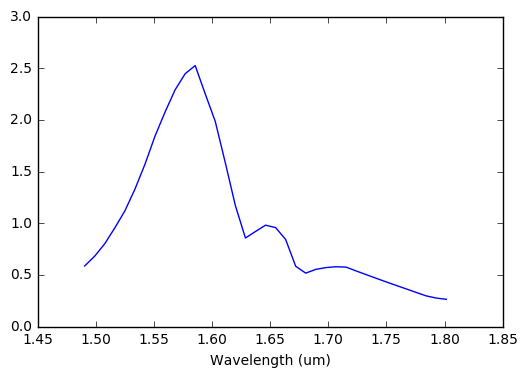

In [27]:
import pyklip.spectra_management as spec
import numpy as np
# T-type spectrum similar to 51 Eridani B in H-band.
reduc_spectrum = "t1000g100nc"
planet_spectrum_dir = glob.glob(os.path.join(pykliproot,"spectra","*",reduc_spectrum+".flx"))[0]
# Wavelengths channels in a H-band GPI cube
wvs =  np.linspace(1.4904, 1.8016, 37,endpoint=True)

# Interpolate spectrum
spectrum = spec.get_planet_spectrum(planet_spectrum_dir,wvs)[1]

## For GPI, it is possible to simply indicate the spectral band.
#spectrum = spec.get_planet_spectrum(planet_spectrum_dir,"H")[1]

import matplotlib.pyplot as plt
plt.plot(wvs,spectrum)
plt.xlabel("Wavelengths (um)")

In [ ]:
# Definition of the cross correlation object
filename = "bet_Pic_test-KL*-speccube.fits"
cc_obj = CrossCorr(filename,kernel_type="gaussian",label="pyklip",kernel_width=1.0,
                   collapse=True,weights=spectrum,folderName=spectrum))

In [ ]:

# filename = "bet_Pic_test-KL*-speccube.fits"
# snr_obj = StatPerPix(filename,
#                          N_threads=None,label="FMMF",IOWA = None,
#                          type="SNR",overwrite=overwrite,GOI_list_folder=GOI_list_folder,mute=mute,resolution=resolution)

### Run FMMF
FMMF is meant to be ran on 16 (or above) cores machine with 60GB (or above) of RAM. Even with such computers, the code will take many hours to days to run on a normal dataset. Therefore, an iPython notebook is not an optimal mean to run this code. One should consider running a script with the linux command *nice* to let it run in the background. The ideal environment for this FMMF implementation is a supercluster where several dataset can be ran in parallel.

In [ ]:
inputDir = "../tests/data/"
outputDir = inputDir

FMMFObj.initialize(inputDir=inputDir,
                   outputDir=outputDir,
                   spectrum = "t1800g100nc",
                   compact_date="myDataDate")
FMMFObj.calculate()
FMMFObj.save()

## Advanced Features

**This section is in progress.**

Most of them are automatically treated by the FMMF object but one could want to take a closer look:
Sectors Definition, spectrum, Overlap, PSF cube, spectral type of the target, fakes management, noFM

Also all kppPerDir related features when reducing campaign data.